# New York City Real Estate Time Series Analysis

## Business Problem

New York City is known to be the most exciting city to live in for its diversity, culture, and opportunity. Since NYC is a metro for apartment rentals, our goal as a real estate agency is to find areas in NYC that has potential for investing in.

Our main questions to answer will be:

- Which zip codes will bring profit in the future?

- What codes based on our data has the highest ROI and will it continue to generate profit?

## Business Value

Why is this information important for our client? We are looking to determine which zip codes holds future value based on prior historical information provided by Zillow's [Data](https://www.zillow.com/research/data/). The outcome is provide home value analysis for aspiring landlords, home owners and property investers on which areas in NYC that will bring the best return on investment.

# Load the Data/Filtering for Chosen Zipcodes

Here we will filter out our dataframe to only New York City.

In [1]:
import pandas as pd
import pandas.tseries
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
import statsmodels.api as sm

# Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
# Auto Correlation
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# AR Autoregressive
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest
from pmdarima.model_selection import train_test_split

from help_functions import *

warnings.filterwarnings('ignore')

In [2]:
# load the dataset
df = pd.read_csv('zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [3]:
# filter city column to New York
nyc_df = df[df['City'] == 'New York']
nyc_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,62122,11436,New York,NY,New York,Queens,8009,119000.0,119400.0,119900.0,...,383800,382200,381000,382500,385600,387600,388700,390600,395100,400300
8303,62078,11366,New York,NY,New York,Queens,8304,231800.0,232000.0,232300.0,...,830000,839100,847800,854900,859600,861700,865600,871900,882700,893600
8387,61783,10307,New York,NY,New York,Richmond,8388,186700.0,186800.0,186900.0,...,522000,525600,527900,533800,543300,550800,559300,566900,571600,575900
9911,62075,11363,New York,NY,New York,Queens,9912,295000.0,296200.0,297700.0,...,1032000,1043700,1049800,1047900,1041200,1035400,1040700,1048600,1052100,1051300


In [4]:
# look at the county names in new york city
nyc_df['CountyName'].unique()

array(['Bronx', 'Kings', 'Queens', 'New York', 'Richmond'], dtype=object)

The counties that we are going to be focused on will be Queens, Kings, Bronx, Richmond and New York. Later on we will change the county name column to boroughs.

# Data Exploration

## Preprocessing

In [5]:
# melt the data
melt_df = melt_data(nyc_df)
melt_df

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,10467,61807,7,New York,NY,New York,Bronx,1996-04-01,152900.0
1,11226,62037,11,New York,NY,New York,Kings,1996-04-01,162000.0
2,11375,62087,13,New York,NY,New York,Queens,1996-04-01,252400.0
3,11235,62045,14,New York,NY,New York,Kings,1996-04-01,190500.0
5,10128,61703,22,New York,NY,New York,New York,1996-04-01,3676700.0
...,...,...,...,...,...,...,...,...,...
30205,11436,62122,8009,New York,NY,New York,Queens,2018-04-01,400300.0
30206,11366,62078,8304,New York,NY,New York,Queens,2018-04-01,893600.0
30207,10307,61783,8388,New York,NY,New York,Richmond,2018-04-01,575900.0
30208,11363,62075,9912,New York,NY,New York,Queens,2018-04-01,1051300.0


In [6]:
# check for missing values
melt_df.isna().sum()

RegionName    0
RegionID      0
SizeRank      0
City          0
State         0
Metro         0
CountyName    0
time          0
value         0
dtype: int64

In [7]:
# check for duplicated values
melt_df.duplicated().value_counts()

False    29058
dtype: int64

In [8]:
# drop unncessary columns
melt_df.drop(columns=['RegionID','SizeRank', 'State', 'Metro'], axis = 1, inplace = True)
nyc = melt_df.copy()

In [9]:
# rename Region Name and County columns to Zipcode and Borough
nyc = nyc.rename({'RegionName':'Zipcode'}, axis = 'columns')
nyc = nyc.rename({'CountyName':'Borough'}, axis = 'columns')

In [10]:
# check how many zip codes we're working with
len(nyc.Zipcode.unique())

114

In [11]:
# replace the previous county names to their prospective borough name
nyc['Borough'].replace({'Kings': 'Brooklyn', 'Richmond': 'Staten Island', 'New York': 'Manhattan'}, inplace = True)

In [12]:
# set the index by time
nyc.set_index('time', inplace = True)

## EDA/Visualization

## Highest Mean Value by Borough

In [13]:
def plot_mean(df, col ,value):
    df.sort_values().plot.barh(color = 'g')
    plt.title(f'Average Value by {col}')
    plt.ylabel(f'{col}')
    plt.xlabel(f'Value ($) in {value}')
    return plt.show()

In [14]:
# Group by borough to check the highest average borough
borough = nyc.groupby('Borough').value.mean().sort_values(ascending = False).round()
borough

Borough
Manhattan        5314744.0
Brooklyn          582269.0
Queens            439516.0
Bronx             366853.0
Staten Island     339585.0
Name: value, dtype: float64

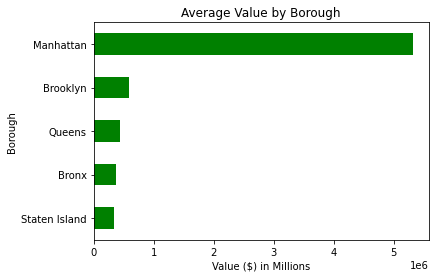

In [15]:
# plot average value by borough
plot_mean(borough , 'Borough', 'Millions')

Manhattan has the highest average value.

## Highest Mean Value Zip Code

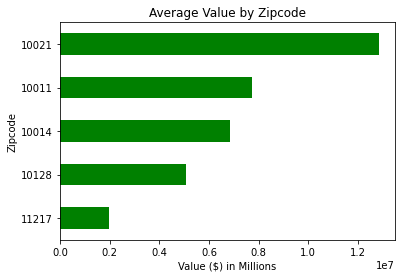

In [16]:
zipcodes = nyc.groupby('Zipcode').value.mean().sort_values(ascending=False).round().head()
plot_mean(zipcodes, 'Zipcode', 'Millions')

The top 5 highest average home value is in 10021, 10011, 10014, 10128, 11217

10021, 10011, 10014, 10128 are all based in Manhattan and 11217 is based in Brooklyn.

## Highest Mean Value Zip Code by Borough

In [17]:
def get_borough_mean(col):
    x = group[col].sort_values(ascending=False).head(10).round()
    return x

In [18]:
# Group by Borough and Zipcode to find the value mean
group = nyc.groupby(['Borough', 'Zipcode']).value.mean()
group

Borough        Zipcode
Bronx          10456      313059.615385
               10459      292612.921348
               10461      338021.132075
               10462      308724.150943
               10463      432449.056604
                              ...      
Staten Island  10308      353755.094340
               10309      398166.415094
               10310      322537.358491
               10312      361979.622642
               10314      352084.528302
Name: value, Length: 114, dtype: float64

### Manhattan

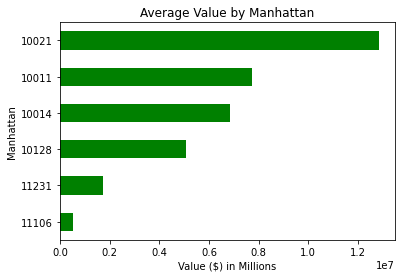

Zipcode
10021    12854267.0
10011     7755844.0
10014     6836902.0
10128     5085436.0
11231     1748707.0
11106      503196.0
Name: value, dtype: float64

In [19]:
plot_mean(group['Manhattan'], 'Manhattan', 'Millions')
get_borough_mean('Manhattan')

### Brooklyn

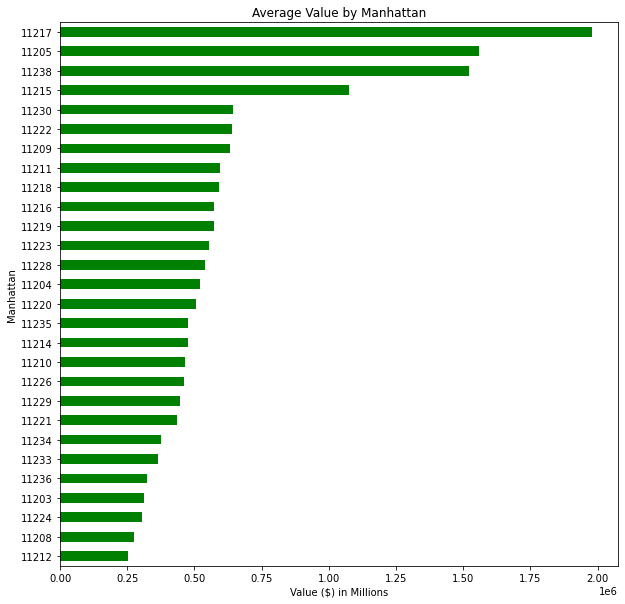

Zipcode
11217    1977407.0
11205    1557881.0
11238    1520451.0
11215    1074962.0
11230     644989.0
11222     640048.0
11209     632700.0
11211     595167.0
11218     590362.0
11216     572172.0
Name: value, dtype: float64

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
plot_mean(group['Brooklyn'], 'Manhattan', 'Millions')
get_borough_mean('Brooklyn')

### Queens

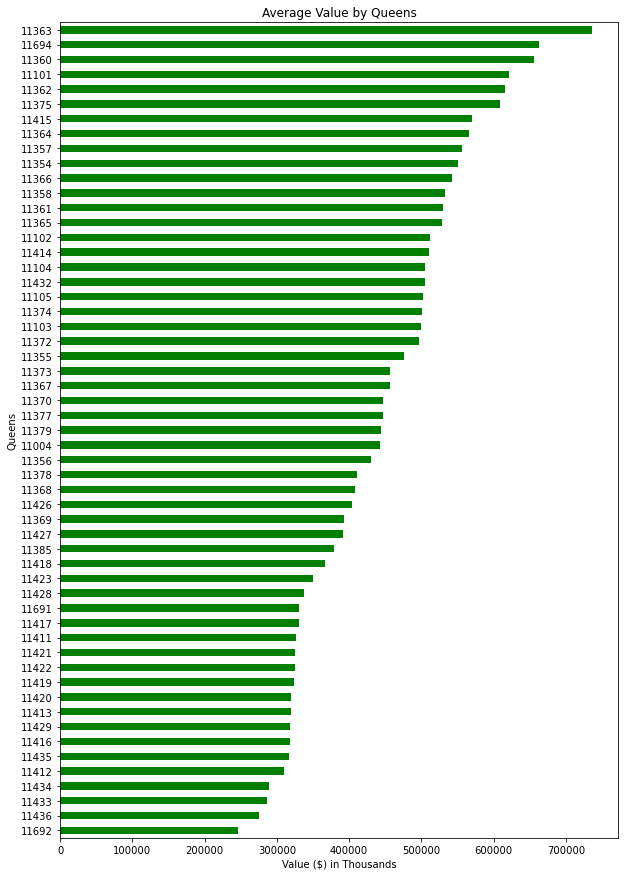

Zipcode
11363    735301.0
11694    663122.0
11360    656026.0
11101    621317.0
11362    615290.0
11375    608117.0
11415    569557.0
11364    565134.0
11357    556737.0
11354    549951.0
Name: value, dtype: float64

In [21]:
fig, ax = plt.subplots(figsize=(10,15))
plot_mean(group['Queens'], 'Queens', 'Thousands')
get_borough_mean('Queens')

### Staten Island

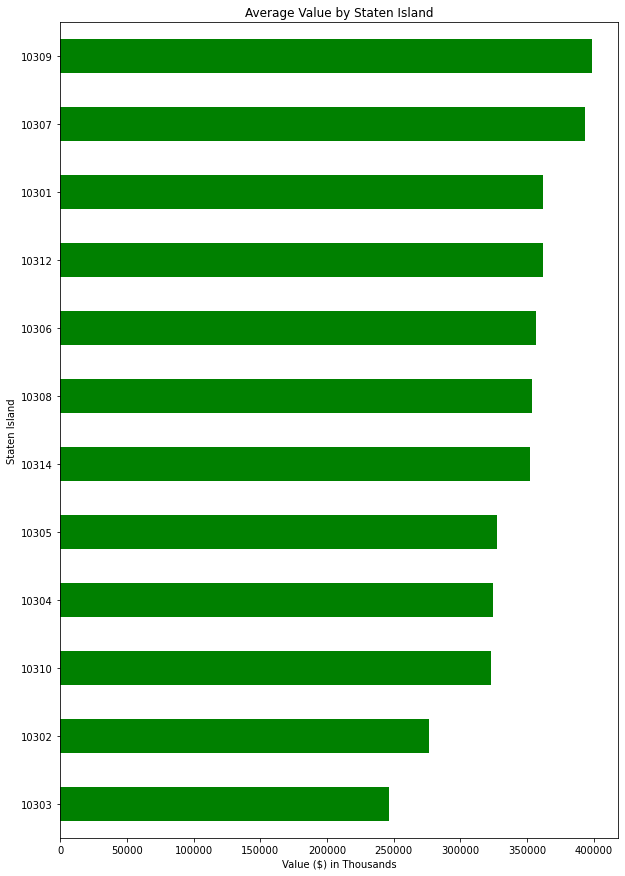

Zipcode
10309    398166.0
10307    393559.0
10301    362121.0
10312    361980.0
10306    356281.0
10308    353755.0
10314    352085.0
10305    327387.0
10304    324466.0
10310    322537.0
Name: value, dtype: float64

In [22]:
fig, ax = plt.subplots(figsize=(10,15))
plot_mean(group['Staten Island'], 'Staten Island', 'Thousands')
get_borough_mean('Staten Island')

### Bronx

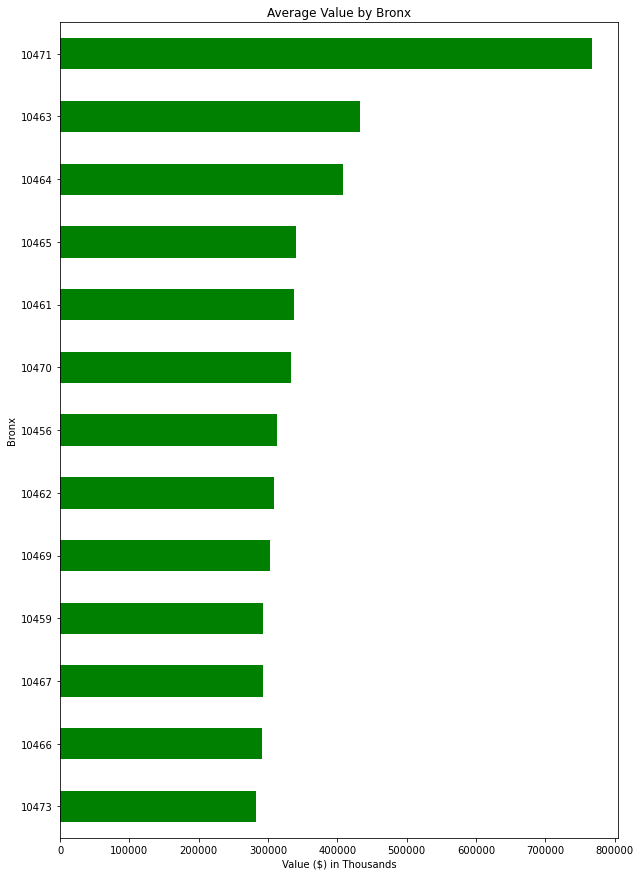

Zipcode
10471    766487.0
10463    432449.0
10464    408179.0
10465    340501.0
10461    338021.0
10470    332445.0
10456    313060.0
10462    308724.0
10469    303177.0
10459    292613.0
Name: value, dtype: float64

In [23]:
fig, ax = plt.subplots(figsize=(10,15))
plot_mean(group['Bronx'], 'Bronx', 'Thousands')
get_borough_mean('Bronx')

### Trend Post Market Crisis

In [24]:
trend = nyc['2009':]
trend = trend.groupby('time').aggregate({'value':'mean'})
trend

,value
time,
2009-01-01,7.724545e+05
2009-02-01,7.706821e+05
2009-03-01,7.696062e+05
2009-04-01,7.690875e+05
2009-05-01,7.669411e+05
...,...
2017-12-01,1.176734e+06
2018-01-01,1.182094e+06
2018-02-01,1.185925e+06


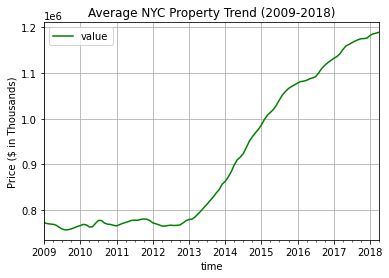

In [25]:
plot_trend(trend, 'Average NYC Property Trend (2009-2018)')

We see here that there is an annual linear increase starting in 2013

## Average ROI

The metric we will be using will be Zillow's most citied metric the Zillow Home Value Index (ZHVI). The formula we will be using according to the ZHVI is growth over past year and forecasted growth over the next year.

For example, to show how much home prices have grown for a region over the prior year and how much they are forecasted to grow in the coming year the formula is shown below:

***
$\mathbf{\text{Calculating historial growth over the past year}}$<br>
***
$$ Price Growth = 100 * ((this month current year - this month last year) / this month last year) $$
***
$\mathbf{\text{Calculating forecasted growth over the next year}}$<br>
***
$$ Forecasted Price Growth = 100 * ((this month next year - this month current year) / this month current year) $$

In [26]:
nyc_8yrs = nyc_df.copy()
nyc_8yrs.drop(columns = nyc_df.loc[:,'1996-04':'2009-12'], inplace = True)


In [27]:
# change column name to avg roi
nyc_8yrs['ROI'] = 100*((nyc_8yrs['2018-04']-nyc_8yrs['2010-01'])/nyc_8yrs['2010-01'])

In [28]:
nyc_8yrs.isnull().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2018-01       0
2018-02       0
2018-03       0
2018-04       0
ROI           2
Length: 108, dtype: int64

In [29]:
nyc_8yrs[nyc_8yrs['ROI'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
36,61796,10456,New York,NY,New York,Bronx,37,NaN,NaN,NaN,...,357100,356500,357200,362000,368500,374100,379800,388100,394400,NaN
1299,62004,11101,New York,NY,New York,Queens,1300,NaN,NaN,NaN,...,739000,708300,698500,711200,742900,767300,769700,767200,782500,NaN


In [30]:
nyc_8yrs = melt_data_roi(nyc_8yrs)

nyc_8yrs.drop(columns=['RegionID','SizeRank', 'State', 'Metro'], axis = 1, inplace = True)

In [31]:
nyc_8yrs = nyc_8yrs.rename({'RegionName':'Zipcode'}, axis = 'columns')
nyc_8yrs = nyc_8yrs.rename({'CountyName': 'Borough'}, axis = 'columns')

In [32]:
# replace the previous county names to their prospective borough name
nyc_8yrs['Borough'].replace({'Kings': 'Brooklyn', 'Richmond': 'Staten Island', 'New York': 'Manhattan'}, inplace = True)

In [33]:
# we have 128 missing values for ROI
nyc_8yrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11328 entries, 0 to 11399
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Zipcode  11328 non-null  int64         
 1   City     11328 non-null  object        
 2   Borough  11328 non-null  object        
 3   ROI      11200 non-null  float64       
 4   time     11328 non-null  datetime64[ns]
 5   value    11328 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 619.5+ KB


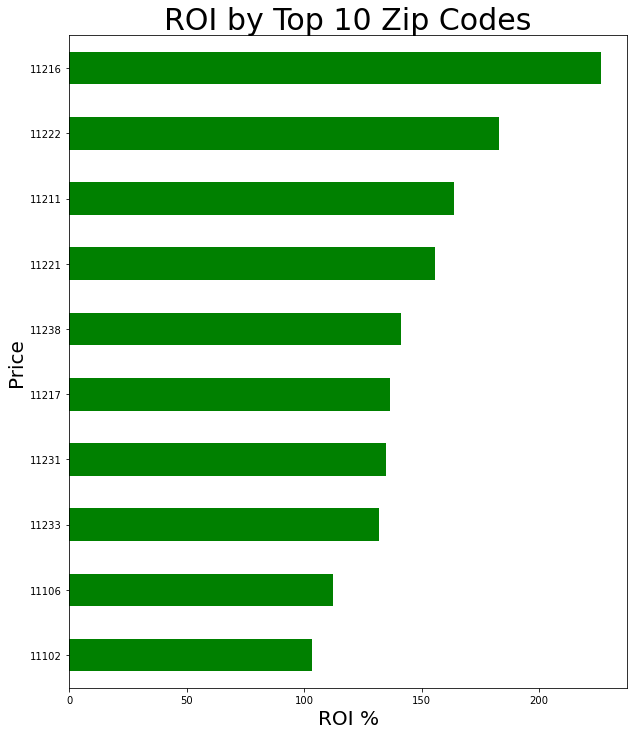

In [34]:
# Group and plot the top 10 Zip Code's return on investment 
group_roi = nyc_8yrs.groupby(['Zipcode']).ROI.mean().sort_values(ascending=False)
fig,ax=plt.subplots(figsize=(10,12))
group_roi.head(10).sort_values().plot.barh(color = 'g')
plt.title('ROI by Top 10 Zip Codes', fontsize=30)
plt.xlabel('ROI %', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.show()

In [41]:
group_roi[11222]

182.84305669679492

## ROI by Borough

In [35]:
borough_ROI = nyc_8yrs.groupby(['Borough', 'Zipcode']).ROI.mean()
borough_ROI

Borough        Zipcode
Bronx          10456            NaN
               10459      45.377258
               10461      20.698577
               10462      32.062188
               10463      34.004474
                            ...    
Staten Island  10308      32.189707
               10309      28.842756
               10310      37.612921
               10312      30.735402
               10314      39.949622
Name: ROI, Length: 114, dtype: float64

## Manhattan

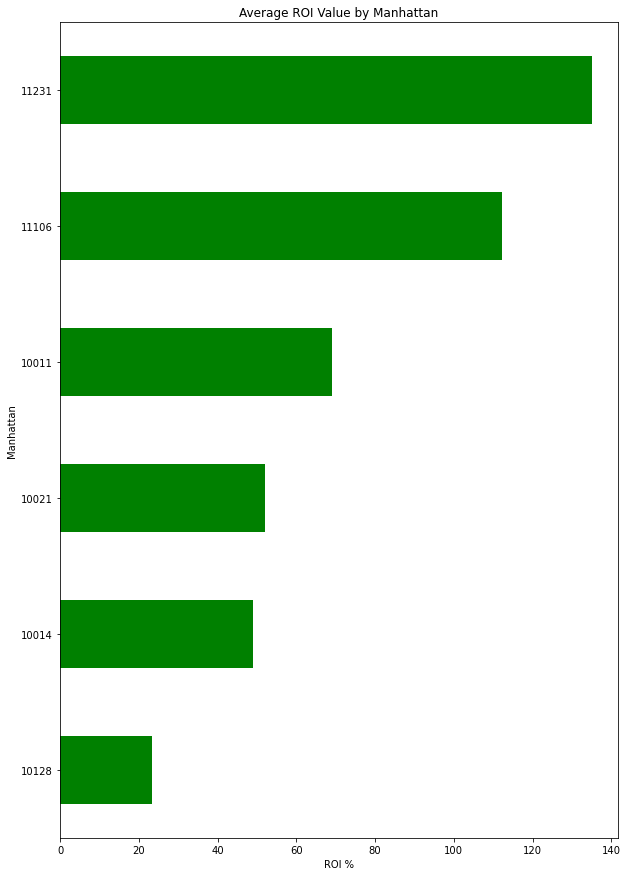

Zipcode
11231    134.951381
11106    112.283737
10011     69.159237
10021     52.141643
10014     49.045932
10128     23.443297
Name: ROI, dtype: float64

In [36]:
fig, ax = plt.subplots(figsize=(10,15))
plot_ROI(borough_ROI['Manhattan'], 'Manhattan')
get_borough_ROI(borough_ROI['Manhattan'])

## Brooklyn

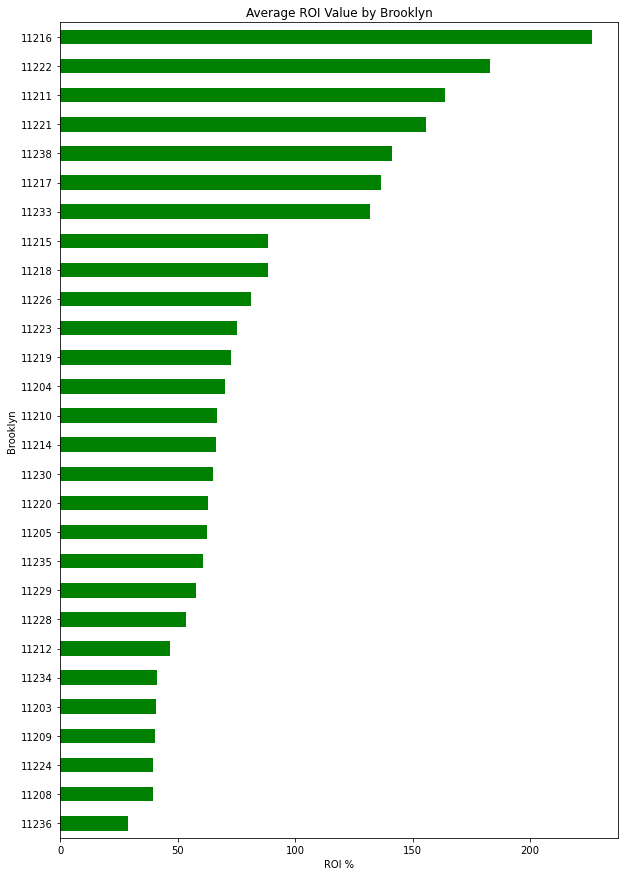

Zipcode
11216    226.132191
11222    182.843057
11211    163.758934
11221    155.593468
11238    141.225650
11217    136.710910
11233    131.729201
11215     88.642287
11218     88.585110
11226     81.086670
Name: ROI, dtype: float64

In [37]:
fig, ax = plt.subplots(figsize=(10,15))
plot_ROI(borough_ROI['Brooklyn'], 'Brooklyn')
get_borough_ROI(borough_ROI['Brooklyn'])

## Queens

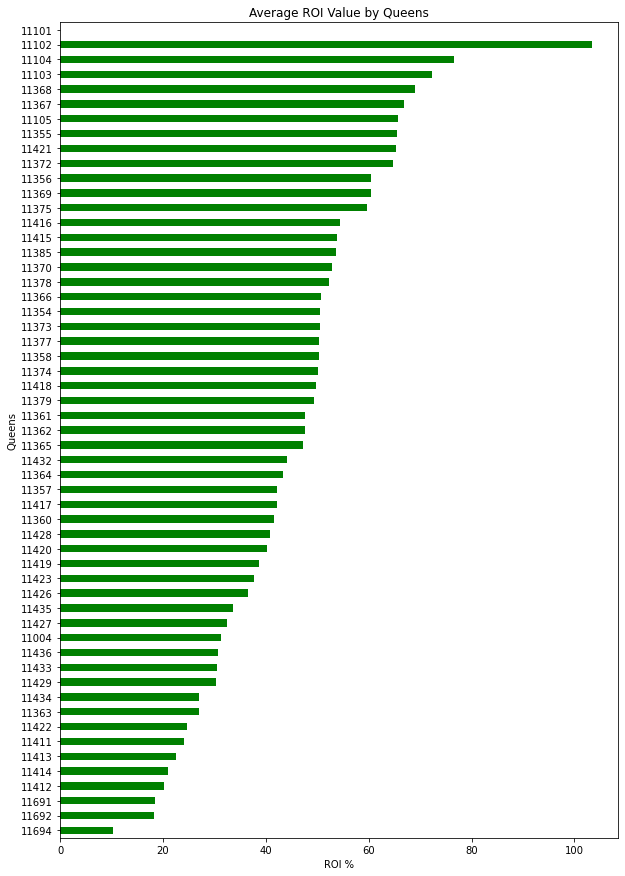

Zipcode
11102    103.308958
11104     76.564195
11103     72.297297
11368     68.940960
11367     66.782502
11105     65.691869
11355     65.433934
11421     65.386941
11372     64.685649
11356     60.539629
Name: ROI, dtype: float64

In [38]:
fig, ax = plt.subplots(figsize=(10,15))
plot_ROI(borough_ROI['Queens'], 'Queens')
get_borough_ROI(borough_ROI['Queens'])

## Staten Island

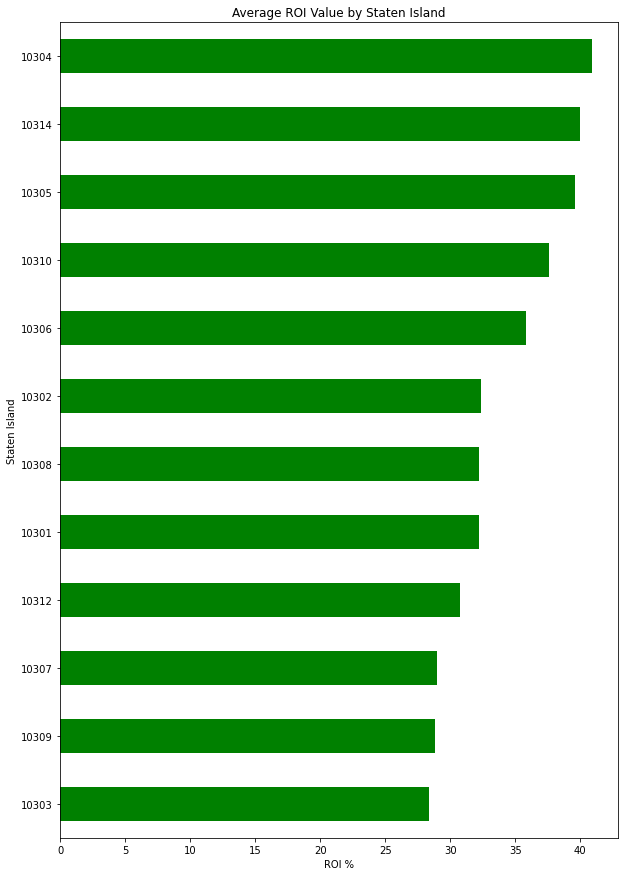

Zipcode
10304    40.866791
10314    39.949622
10305    39.577201
10310    37.612921
10306    35.840485
10302    32.374561
10308    32.189707
10301    32.177863
10312    30.735402
10307    28.952082
Name: ROI, dtype: float64

In [39]:
fig, ax = plt.subplots(figsize=(10,15))
plot_ROI(borough_ROI['Staten Island'], 'Staten Island')
get_borough_ROI(borough_ROI['Staten Island'])

## Bronx

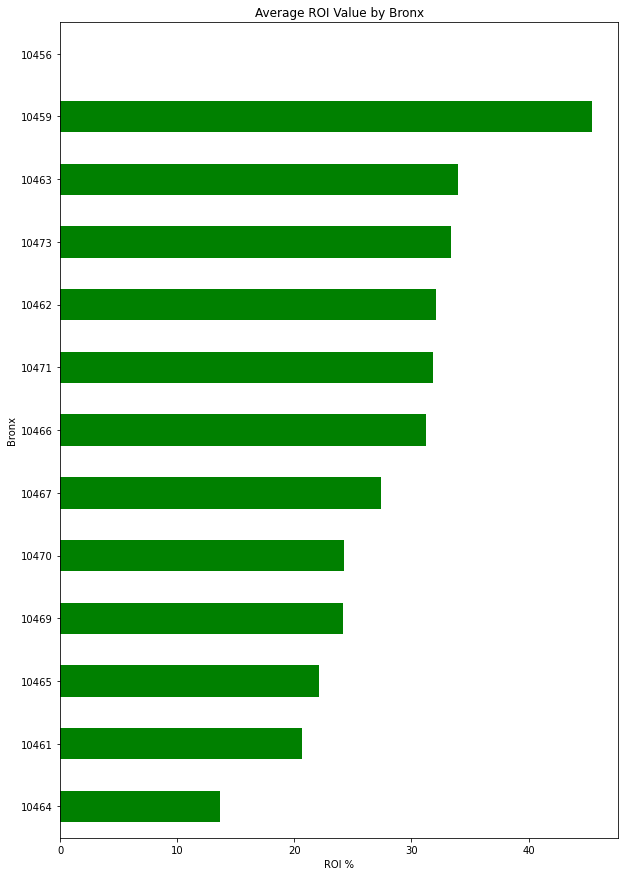

Zipcode
10459    45.377258
10463    34.004474
10473    33.398121
10462    32.062188
10471    31.860913
10466    31.280941
10467    27.369704
10470    24.266667
10469    24.118846
10465    22.116110
Name: ROI, dtype: float64

In [40]:
fig, ax = plt.subplots(figsize=(10,15))
plot_ROI(borough_ROI['Bronx'], 'Bronx')
get_borough_ROI(borough_ROI['Bronx'])